<a href="https://colab.research.google.com/github/rpadmanabhan/probability-I-proj/blob/main/DPPM_clustering_turn_in.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Module Installations
!pip install --quiet pyro-ppl
!pip install --quiet h5py
!pip install --quiet anndata
!pip install --quiet scanpy
!pip install --quiet wandb
!pip install --quiet rpy2
!pip install --quiet python-igraph
!pip install --quiet louvain

     |████████████████████████████████| 678 kB 10.0 MB/s 
     |████████████████████████████████| 91 kB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 9.7 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.9 MB/s 
     |████████████████████████████████| 63 kB 2.9 MB/s 
     |████████████████████████████████| 1.7 MB 8.0 MB/s 
     |████████████████████████████████| 140 kB 71.1 MB/s 
     |████████████████████████████████| 180 kB 70.4 MB/s 
     |████████████████████████████████| 97 kB 9.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 3.2 MB 10.4 MB/s 
     |████████████████████████████████| 2.1 MB 7.9 MB/s 


In [2]:
# Module Imports
import collections
import functools
from pprint import pprint

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm


import seaborn as sns
import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

import anndata
import h5py
import scanpy
import wandb

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)




In [3]:
# Globally set tensors on GPU - Change accordingly
torch.set_default_tensor_type("torch.cuda.DoubleTensor")


# Data download

In [ ]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')
#CellRanger Starvation h5ad data
download_file('10.22002/D1.1798','.gz')
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')
#Panther annotations
download_file('10.22002/D1.1820','.gz')
#GO Terms
download_file('10.22002/D1.1822','.gz')
#Saved DeSeq2 Results for Fed/Starved (Differentially expressed under starvation --> perturbed genes)
download_file('10.22002/D1.1810','.gz')
#Saved gene modules adata
download_file('10.22002/D1.1813','.gz')
#Gene Markers to plot (for cell atlas) --> Fig 2 heatmap
download_file('10.22002/D1.1809','.gz')

!gunzip *.gz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/26058 [00:00<?, ?B/s]

  0%|          | 0/45376 [00:00<?, ?B/s]

  0%|          | 0/479630 [00:00<?, ?B/s]

  0%|          | 0/528 [00:00<?, ?B/s]

  0%|          | 0/515 [00:00<?, ?B/s]

  0%|          | 0/227 [00:00<?, ?B/s]

  0%|          | 0/224 [00:00<?, ?B/s]

  0%|          | 0/59338 [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?B/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/filtered_Xiuli_An_2014.txt ./sample_data/

# Dirchlet Process Poisson-lognormal Mixture model and SVI for param estimation

In [8]:
class DPPLMClust:
  ''' Dirchlet Process LogNormal-Poissson Mixture Model Clustering
  '''
  def __init__(self, *args, **kwargs):
      '''
      '''
      # mandatory
      self.data = kwargs["data"]
      self.num_clusters = kwargs["num_clusters"]
      self.alpha = kwargs["alpha"]

      # optionals
      self.optim = kwargs.get("optim", Adam({"lr": 0.05}))
      self.niter = kwargs.get("niter", 1500)
      self.loss = kwargs.get("loss", Trace_ELBO())

      # others vars used in this class
      self.losses = []
      self.svi  = None


  # Define the "stick-breaking" function that generates our weights, given our samples of Beta
  def mix_weights(self, beta):
      beta1m_cumprod = (1 - beta).cumprod(-1)
      return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

  def model(self, data):
      with pyro.plate("beta_plate", self.num_clusters - 1):
          beta = pyro.sample("beta", Beta(1, self.alpha))

      with pyro.plate("lambda_plate", self.num_clusters):
          lmbda = pyro.sample("lambda", MultivariateNormal(
              loc = torch.zeros(data.shape[1]), scale_tril = torch.eye(data.shape[1])))
          #lmbda = pyro.sample("lambda", MultivariateNormal(loc = torch.zeros(data.shape[1]), covariance_matrix = torch.eye(data.shape[1])))
      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(self.mix_weights(beta)))
          pyro.sample("obs", Poisson(torch.exp(lmbda[z])).to_event(1), obs = data)

  def guide(self, data):
      # Define priors to sample from
      kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample(
          [self.num_clusters - 1]), constraint=constraints.positive)
      mu = pyro.param('mu', lambda: MultivariateNormal(
          loc = torch.ones(data.shape[1]),
          covariance_matrix = torch.eye(data.shape[1])).sample([self.num_clusters]))
      # Vector of variances for each of the d variables
      theta = pyro.param('theta', lambda: HalfCauchy(torch.ones(data.shape[1])).sample(
          [self.num_clusters]))
      # Lower cholesky factor of a correlation matrix
      #concentration = torch.ones(())  # Implies a uniform distribution over correlation matrices
      L_omega = pyro.param("L_omega", lambda: LKJCholesky(data.shape[1], torch.ones(())).sample([self.num_clusters]), constraint=constraints.lower_cholesky)
      # Lower cholesky factor of the covariance matrix
      L_Omega = pyro.param("L_Omega", lambda: torch.bmm(theta.sqrt().diag_embed(), L_omega), constraint=constraints.lower_cholesky)

      phi = pyro.param('phi', lambda: Dirichlet(
          1/self.num_clusters * torch.ones(self.num_clusters)).sample(
              [data.shape[0]]), constraint=constraints.simplex)

      # Define parameters in the model
      with pyro.plate("beta_plate", self.num_clusters - 1):
          q_beta = pyro.sample("beta", Beta(torch.ones(self.num_clusters - 1), kappa))

      with pyro.plate("lambda_plate", self.num_clusters):
          q_lambda = pyro.sample("lambda", MultivariateNormal(loc = mu, scale_tril = L_Omega))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(phi))


  def train_batch(self, loader):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          for bx in loader:
              loss = self.svi.step(bx[0].cuda())
              self.losses.append(loss)

  def train(self):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          loss = self.svi.step(self.data)
          self.losses.append(loss)

  def truncate(self, centers, weights):
      threshold = self.alpha**-1 / 100.
      true_centers = centers[weights > threshold]
      true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
      return true_centers, true_weights

  def var_inference(self):
      self.svi = SVI(self.model, self.guide, self.optim, loss = self.loss)
      self.train()

  def loss_viz(self):
      elbo_plot = plt.figure(figsize=(15, 5))
      elbo_ax = elbo_plot.add_subplot(1, 2, 1)
      elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI")
      elbo_ax.set_ylabel("ELBO")
      elbo_ax.set_xlabel("Iteration Number")
      elbo_ax.plot(np.arange(self.niter), self.losses)

      autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
      autocorr_ax.acorr(np.asarray(self.losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
      autocorr_ax.set_xlim(0, 500)
      autocorr_ax.axhline(0, ls="--", c="k", lw=1)
      autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI")
      autocorr_ax.set_xlabel("Lag")
      autocorr_ax.set_ylabel("Autocorrelation")
      elbo_plot.tight_layout()
      plt.show()

  def cluster_2d_viz(self):
      # We make a point-estimate of our model parameters using the posterior means of mu and phi for the centers and weights
      Bayes_Centers_01, Bayes_Weights_01 = self.truncate(
          torch.exp(pyro.param("mu")).detach(),
          torch.mean(pyro.param("phi").detach(), dim=0))
      plt.figure(figsize=(15, 5))
      plt.subplot(1, 2, 1)
      plt.scatter(self.data[:, 0].cpu(), self.data[:, 1].cpu(), color="blue")
      plt.scatter(Bayes_Centers_01[:, 0].cpu(), Bayes_Centers_01[:, 1].cpu(), color="red")
      plt.legend(["Simulated Data", "Cluster Centers Identified"])
      plt.title("Clustering using DPMM on simulated data.")

# Simulation Data

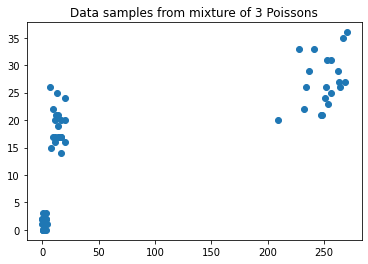

In [9]:
# Simulation data - Multivariate PoissonLogNormal of dimension 2 with 3 clusters
theta1 = MultivariateNormal(loc = 3 * torch.ones(2), covariance_matrix = torch.eye(2)).sample([1])
theta2 = MultivariateNormal(loc = torch.zeros(2), covariance_matrix = torch.eye(2)).sample([1])
theta3 = MultivariateNormal(loc = 4 * torch.ones(2), covariance_matrix = torch.eye(2)).sample([1])
test_data = torch.cat(
    (Poisson(torch.exp(theta1)).to_event(1).sample([20]),
     Poisson(torch.exp(theta2)).to_event(1).sample([20]),
     Poisson(torch.exp(theta3)).to_event(1).sample([20])), axis = 0
)

test_data = test_data.reshape(60, 2)
plt.scatter(test_data[:, 0].cpu(), test_data[:, 1].cpu())
#plt.scatter(test_data|[:, 0], test_data[:, 1])
plt.title("Data samples from mixture of 3 Poissons")
plt.show()

## Choose number of clusters = 3

100%|██████████| 5000/5000 [01:05<00:00, 76.56it/s]


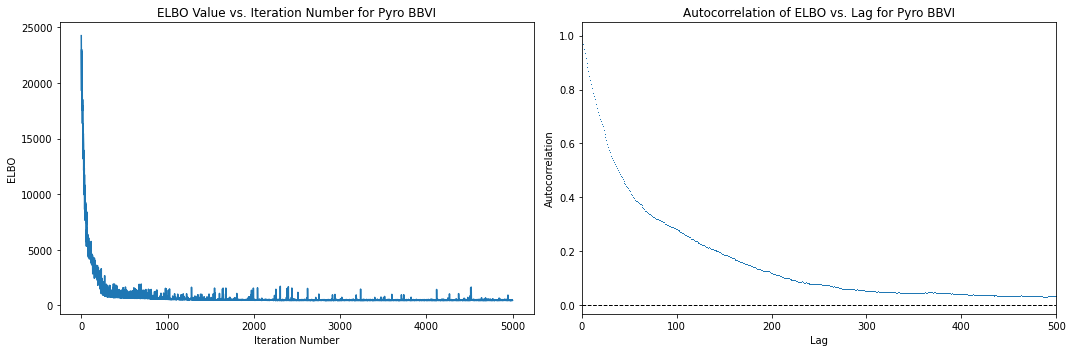

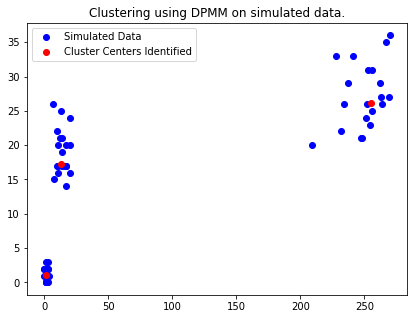

In [10]:
# Try on test data
alpha = 10.0
dpplm_clust = DPPLMClust(data = test_data, num_clusters = 3, alpha = alpha, niter = 5000)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

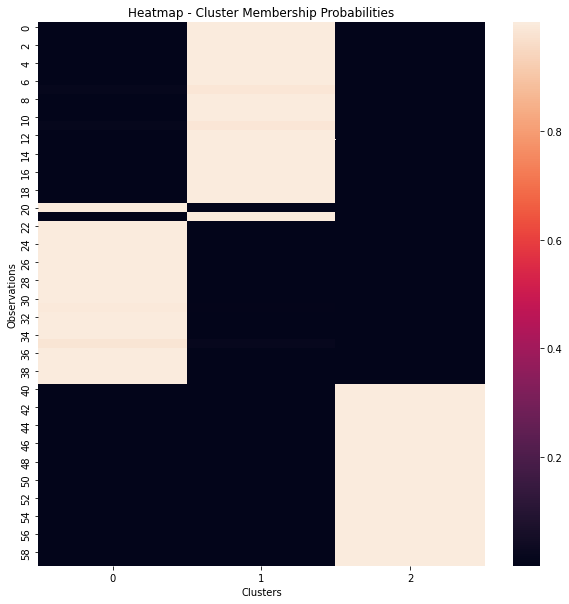

In [12]:
# Cluster memberships
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (10, 10))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

Text(0.5, 1.0, 'Heatmap - Probability that 2 observations are in the same cluster')

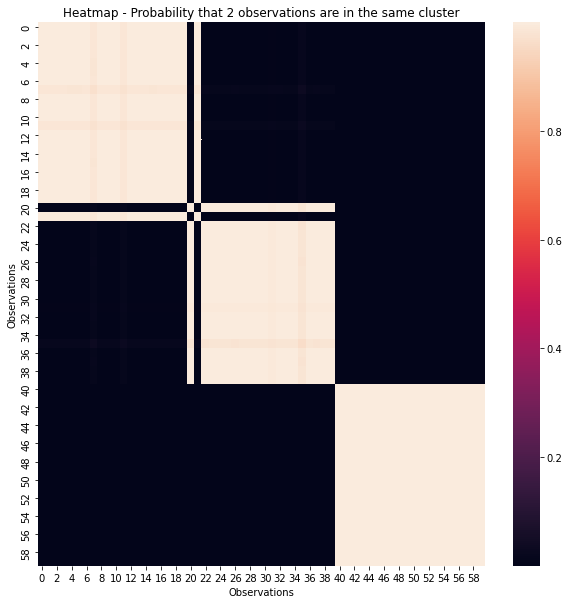

In [14]:
# 2 observations are in the same cluster - visualize clustering of observations
pairwise = probs @ probs.T
fig, axs = plt.subplots(figsize = (10, 10))
sns.heatmap(pairwise)
axs.set_xlabel("Observations")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Probability that 2 observations are in the same cluster")

## Choose number of clusters = 10

100%|██████████| 5000/5000 [01:04<00:00, 77.18it/s]


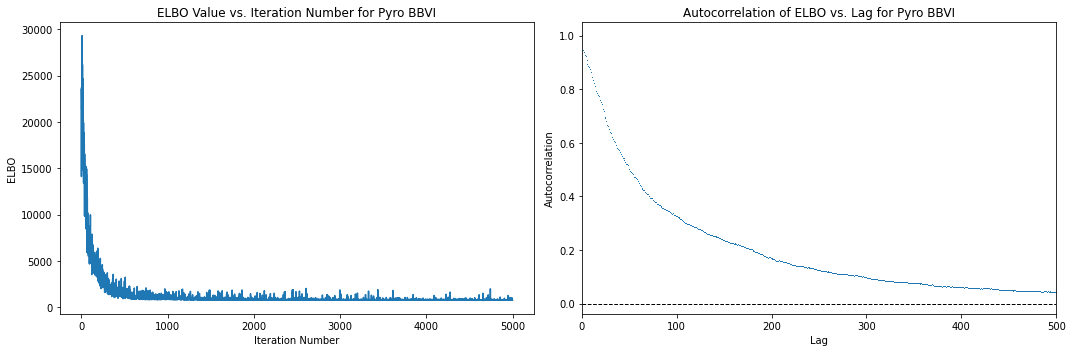

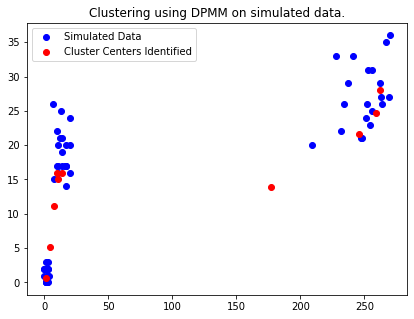

In [15]:
# Try on test data
alpha = 10.0
dpplm_clust = DPPLMClust(data = test_data, num_clusters = 10, alpha = alpha, niter = 5000)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

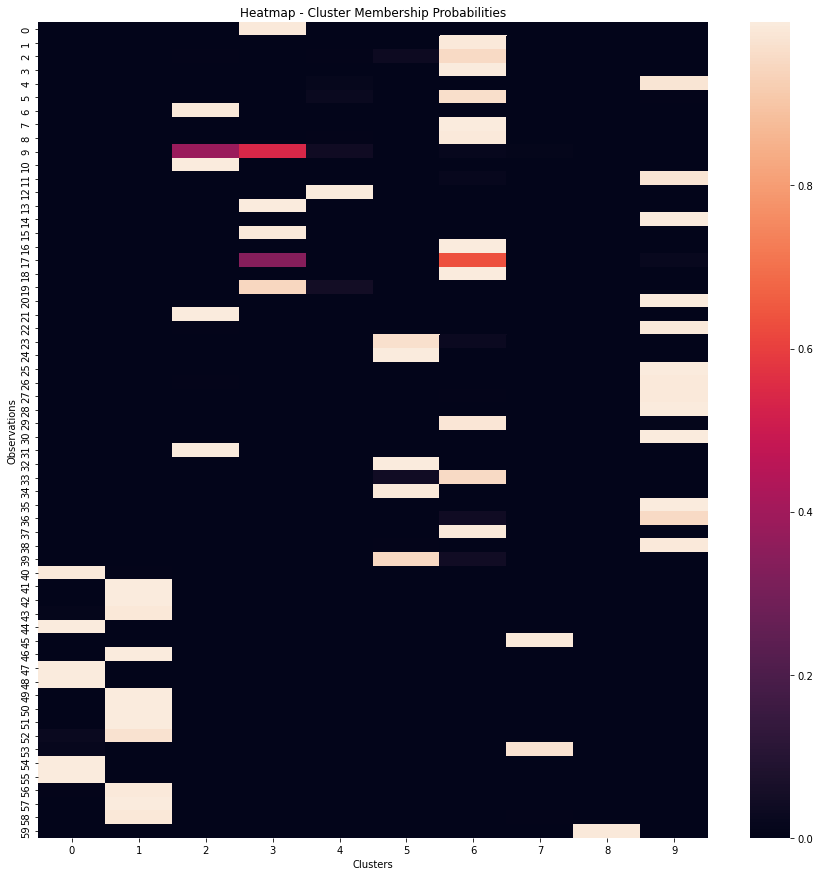

In [16]:
# Cluster memberships
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

Text(0.5, 1.0, 'Heatmap - Probability that 2 observations are in the same cluster')

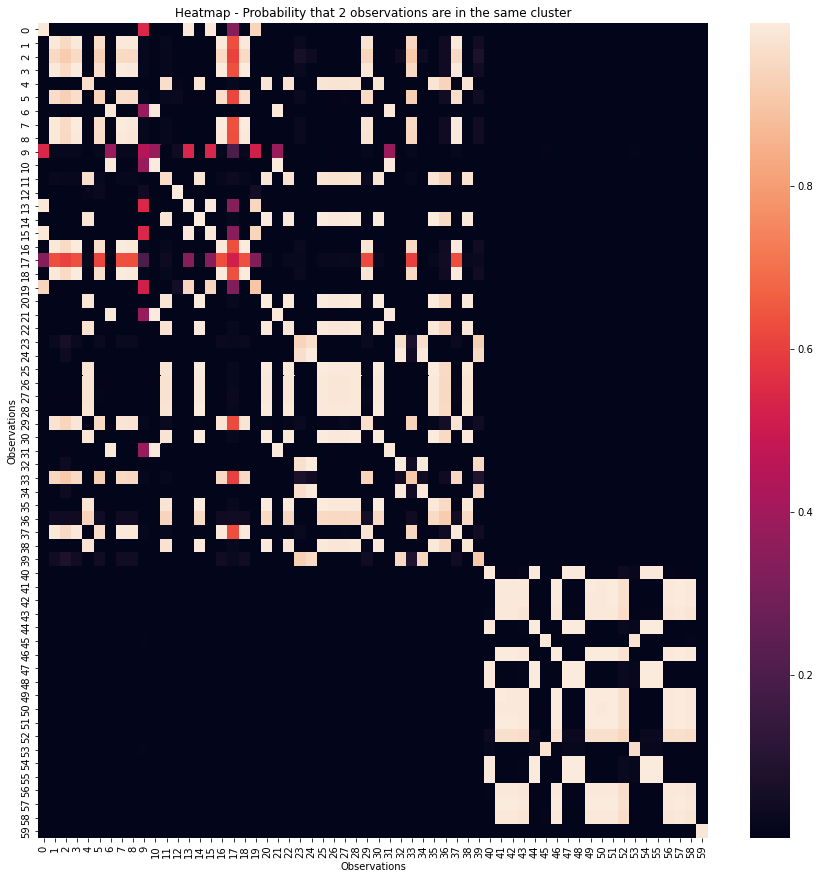

In [17]:
# 2 observations are in the same cluster - visualize clustering of observations
pairwise = probs @ probs.T
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(pairwise)
axs.set_xlabel("Observations")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Probability that 2 observations are in the same cluster")

# Try data from Tara Chari et al 2021 paper

In [ ]:
#Read in previously saved data
bus_fs_clus = anndata.read("D1.1796")
print(bus_fs_clus )

bus_fs_raw = anndata.read("D1.1797")

bus_fs_raw = bus_fs_raw[bus_fs_clus.obs_names,]
bus_fs_raw.obs['fed'] = bus_fs_clus.obs['fed']
bus_fs_raw.obs['cellRanger_louvain'] = bus_fs_clus.obs['cellRanger_louvain']
bus_fs_raw


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'fed', 'cellRanger_louvain'

In [ ]:
# Cluster DE Genes by Expression and Run TopGO Analysis
deGenesDF = pd.read_csv('D1.1810') #deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample_annotations.csv from DeSeq2 analysis
deGenesDF.head()


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,geneClus
0,0,0,1,XLOC_028699,0,Starved,5.554489e-16,1.832981e-14,-1.284301,NaN,NaN,NaN,NaN,NaN,4
1,1,1,2,XLOC_010635,0,Starved,2.528288e-14,8.343350e-13,-1.492625,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4
2,2,2,3,XLOC_011294,0,Starved,8.348790e-14,2.755101e-12,-1.441413,NaN,NaN,NaN,NaN,[nan],0
3,3,3,4,XLOC_034889,0,Starved,1.786565e-13,5.895663e-12,-1.448216,NaN,NaN,['PTHR13680:SF29'],['CDGSH IRON-SULFUR DOMAIN-CONTAINING PROTEIN ...,[nan],1
4,4,4,5,XLOC_030861,0,Starved,8.598653e-12,2.837556e-10,-1.570453,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4


In [ ]:
deGenesDF_sig = deGenesDF[deGenesDF.padjClus < 0.05]


In [ ]:
#Filter raw count dataset for only perturbed genes
bus_fs_raw = anndata.read("D1.1797")
bus_fs_raw = bus_fs_raw [:,np.unique(deGenesDF_sig.Genes)]
bus_fs_raw =bus_fs_raw[bus_fs_clus.obs_names,:]
bus_fs_raw.obs['cellRanger_louvain'] = bus_fs_clus.obs['cellRanger_louvain']
bus_fs_raw.obs['fed'] = bus_fs_clus.obs['fed']


Trying to set attribute `.obs` of view, copying.


In [ ]:
de_gene_adata = anndata.AnnData(X=bus_fs_raw.X.T)
de_gene_adata.var_names = bus_fs_raw.obs_names
de_gene_adata.obs_names = bus_fs_raw.var_names

de_gene_adata_orig = de_gene_adata.copy()
#de_gene_adata

numIntersects = deGenesDF['Genes'].value_counts()
num_intersect = []
for g in de_gene_adata.obs_names: 
    if g in list(deGenesDF['Genes']):
      num_intersect += [numIntersects[g]]
    else:
      num_intersect += [0]
    
de_gene_adata.obs['numIntersects'] = pd.Categorical(num_intersect)

de_gene_adata


AnnData object with n_obs × n_vars = 953 × 13673
    obs: 'numIntersects'

In [ ]:
counts = np.array(de_gene_adata.X.toarray(), dtype = int)
counts.shape


(953, 13673)

(-1.0, 100.0)

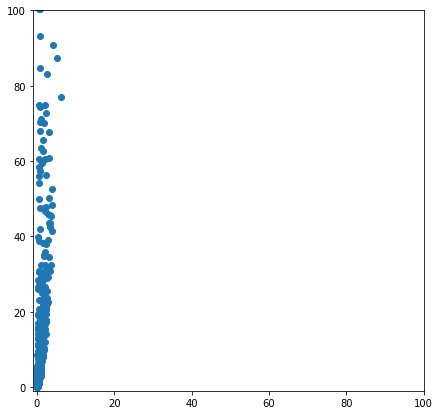

In [ ]:
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(counts.mean(axis = 1), counts.var(axis = 1))
axs.set_xlim([-1, 100])
axs.set_ylim([-1, 100])

In [ ]:
  dppm_clust = DPPLMClust(data = torch.tensor(counts), num_clusters = 14, alpha = 5.0, niter = 5000)
  dppm_clust.var_inference()


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
torch.cuda.empty_cache() 


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:2021: RuntimeWarning: invalid value encountered in true_divide
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


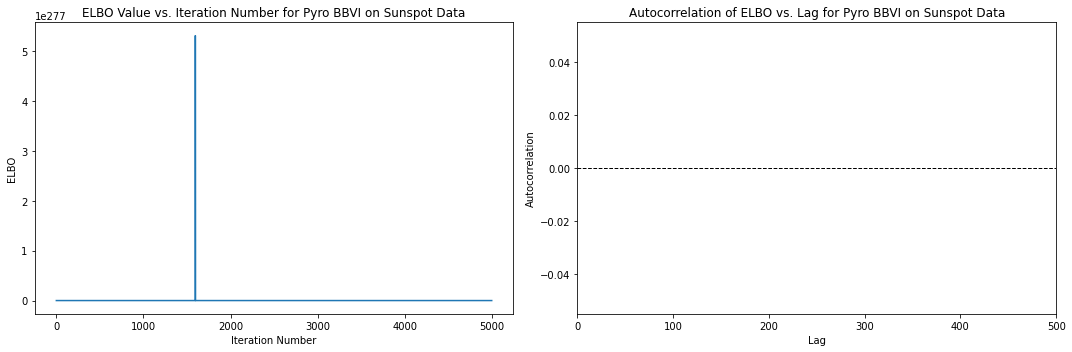

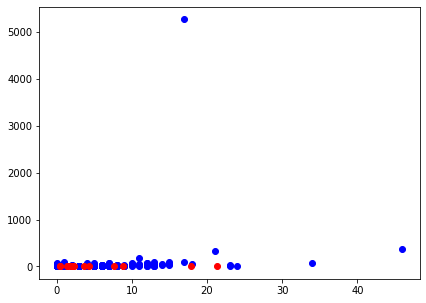

In [ ]:
dppm_clust.loss_viz()
dppm_clust.cluster_2d_viz()

In [ ]:
probs = pyro.param("phi").detach().cpu().numpy()
clusters = collections.defaultdict(list)
clusters_obs = []
i = 0
for row in probs:
    cluster_idx = np.argmax(row) + 1
    clusters[cluster_idx].append(i)
    clusters_obs.append(cluster_idx)
    i += 1

clusters_counts = collections.Counter(clusters_obs)
pprint(sorted(clusters_counts.items()))


[(1, 71),
 (2, 77),
 (3, 58),
 (4, 57),
 (5, 77),
 (6, 59),
 (7, 68),
 (8, 74),
 (9, 70),
 (10, 64),
 (11, 64),
 (12, 70),
 (13, 65),
 (14, 79)]


# Try data from Xiuli An 2014 et al

In [18]:
df = pd.read_csv("sample_data/filtered_Xiuli_An_2014.txt", sep = "\t")
df

,gene_symbol,SRR1106084,SRR1106085,SRR1106087,SRR1106086,SRR1106089,SRR1106088,SRR1106090,SRR1106091,SRR1106092,SRR1106093,SRR1106094,SRR1106095,SRR1106096,SRR1106097,SRR1106098
0,TSPAN6,54876,10347,46742,11884,8852,7764,14076,3992,4245,357,139.0,202,128,20,50
1,DPM1,378667,74142,443054,78987,83801,78130,294221,70741,68161,151587,28555.0,31649,64814,8634,9322
2,SCYL3,165724,21858,215751,38138,33440,27278,180450,31425,34257,119314,25373.0,26971,29412,5489,6350
3,C1orf112,331627,43693,459859,67032,71642,58184,370435,69574,72520,166735,42095.0,39406,12098,3865,4165
4,FUCA2,299783,53783,301332,58771,59406,53610,170972,44835,46555,26287,6575.0,9102,4030,1375,1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,MRPL45,751871,115258,721970,136441,108951,108662,386331,80324,77548,175044,19729.0,22964,84255,10071,15872
8902,GABARAPL3,1675,204,3495,251,642,51,6504,590,561,39298,9575.0,11154,88575,18037,23491
8903,LINC00294,57930,6436,83768,9189,12304,9642,101938,12752,14111,124399,25811.0,30045,25208,3259,4433
8904,MATR3,4177652,683738,4691062,715364,741949,754883,3089438,676970,654168,1470763,304113.0,303892,600151,52448,68068


In [19]:
df = df.drop(columns=['gene_symbol'])
df

,SRR1106084,SRR1106085,SRR1106087,SRR1106086,SRR1106089,SRR1106088,SRR1106090,SRR1106091,SRR1106092,SRR1106093,SRR1106094,SRR1106095,SRR1106096,SRR1106097,SRR1106098
0,54876,10347,46742,11884,8852,7764,14076,3992,4245,357,139.0,202,128,20,50
1,378667,74142,443054,78987,83801,78130,294221,70741,68161,151587,28555.0,31649,64814,8634,9322
2,165724,21858,215751,38138,33440,27278,180450,31425,34257,119314,25373.0,26971,29412,5489,6350
3,331627,43693,459859,67032,71642,58184,370435,69574,72520,166735,42095.0,39406,12098,3865,4165
4,299783,53783,301332,58771,59406,53610,170972,44835,46555,26287,6575.0,9102,4030,1375,1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,751871,115258,721970,136441,108951,108662,386331,80324,77548,175044,19729.0,22964,84255,10071,15872
8902,1675,204,3495,251,642,51,6504,590,561,39298,9575.0,11154,88575,18037,23491
8903,57930,6436,83768,9189,12304,9642,101938,12752,14111,124399,25811.0,30045,25208,3259,4433
8904,4177652,683738,4691062,715364,741949,754883,3089438,676970,654168,1470763,304113.0,303892,600151,52448,68068


In [20]:
data = df.to_numpy(dtype = int)
data.shape

(8906, 15)

In [21]:
dppm_clust = DPPLMClust(data = torch.tensor(data), num_clusters = 20, alpha = 5.0, niter = 5000)
dppm_clust.var_inference()


100%|██████████| 5000/5000 [01:11<00:00, 69.84it/s]


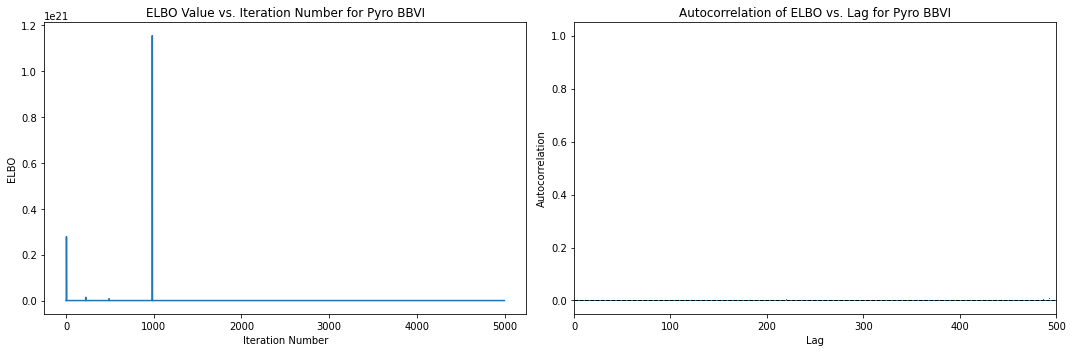

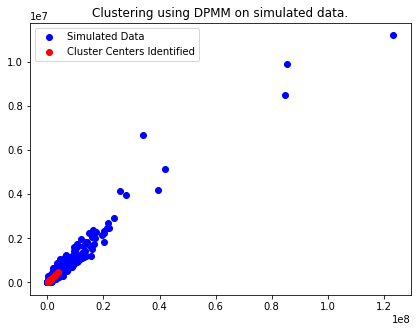

In [22]:
dppm_clust.loss_viz()
dppm_clust.cluster_2d_viz()

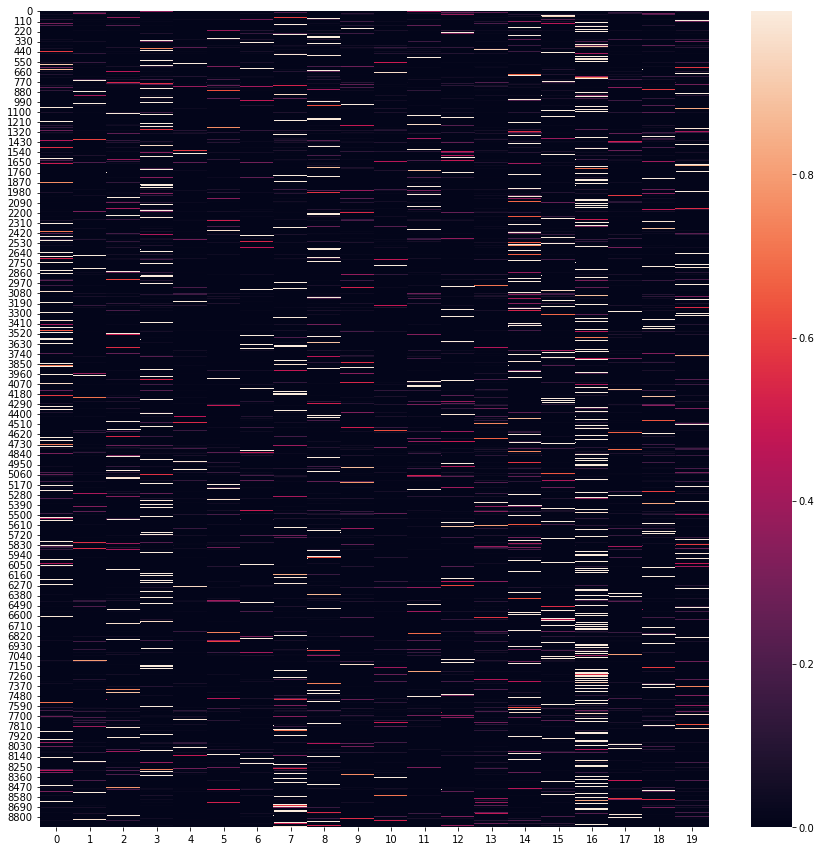

In [23]:
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)